In [38]:
#os.chdir('/home/lichi/jupiter/imaginarium')

from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%pylab inline

import pandas as pd
import numpy as np
import pickle
import os
from random import sample

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sample', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [31]:
with open('preprocessed_data/words_coco_vectors.pickle', 'rb') as f:
    words_vec = pickle.load( f, encoding='latin1')
with open('preprocessed_data/image_coco_vectors.pickle', 'rb') as f:
    img_vec = pickle.load( f, encoding='latin1')

In [32]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
pca.fit(np.concatenate([words_vec, img_vec]))
words_vec = pca.transform(words_vec)
img_vec = pca.transform(img_vec)

### Пример обучающей выборки

In [33]:
def get_training_data(num_samples, num_cards, num_words, len_emb, img_vec, words_veс):
    X_img = []
    y_img_true = []
    for i in range(num_samples):
        img = np.array(sample(range(1,len(img_vec)), num_cards))
        X_img.append(img)
        img_true = sample(list(img), 1)[0]
        y_img_true.append(np.array([1 if x==img_true else 0 for x in X_img[i]]))
    # Эмбеддинги для всех картинок
    X_img = img_vec[X_img].reshape(num_samples,len_emb,num_cards)
    # Эмбеддинги для правильной картинки, размноженные 10 раз
    t =np.array(X_img)[:,:,np.argmax(y_img_true)]
    #X_img_true = np.repeat(t.reshape(t.shape[0],t.shape[1],1),num_cards,axis =2)
    # Эмбеддинги для всех текстов
    X_txt = np.repeat(words_veс.reshape(1, num_words, len_emb),num_samples, axis = 0).reshape(
        num_samples, len_emb, num_words)
    #X_img = X_img.reshape(
    #    num_samples, num_cards, len_emb)
    return(torch.FloatTensor(X_img),
           torch.LongTensor(np.array(y_img_true)),
           torch.FloatTensor(X_txt))



### Сетка

In [34]:
def _sample_gumbel(shape, eps=1e-10, out=None):
    """
    Sample from Gumbel(0, 1)
    based on
    https://github.com/ericjang/gumbel-softmax/blob/3c8584924603869e90ca74ac20a6a03d99a91ef9/Categorical%20VAE.ipynb ,
    (MIT license)
    """
    U = out.resize_(shape).uniform_() if out is not None else torch.rand(shape)
    return - torch.log(eps - torch.log(U + eps))

def _gumbel_softmax_sample(logits, tau=1, eps=1e-10):
    """
    Draw a sample from the Gumbel-Softmax distribution
    based on
    https://github.com/ericjang/gumbel-softmax/blob/3c8584924603869e90ca74ac20a6a03d99a91ef9/Categorical%20VAE.ipynb
    (MIT license)
    """
    dims = logits.dim()
    gumbel_noise = Variable(_sample_gumbel(logits.size(), eps=eps, out=logits.data.new()))
    y = logits + gumbel_noise
    return F.softmax(y / tau, dims - 1)


def gumbel_softmax(logits, tau=0.8, hard=False, eps=1e-10):
    """
    Sample from the Gumbel-Softmax distribution and optionally discretize.
    Args:
      logits: `[batch_size, n_class]` unnormalized log-probs
      tau: non-negative scalar temperature
      hard: if ``True``, take `argmax`, but differentiate w.r.t. soft sample y
    Returns:
      [batch_size, n_class] sample from the Gumbel-Softmax distribution.
      If hard=True, then the returned sample will be one-hot, otherwise it will
      be a probability distribution that sums to 1 across classes
    Constraints:
    - this implementation only works on batch_size x num_features tensor for now
    based on
    https://github.com/ericjang/gumbel-softmax/blob/3c8584924603869e90ca74ac20a6a03d99a91ef9/Categorical%20VAE.ipynb ,
    (MIT license)
    """
    shape = logits.size()
    assert len(shape) == 2
    y_soft = _gumbel_softmax_sample(logits, tau=tau, eps=eps)
    if hard:
        _, k = y_soft.max(-1)
        # this bit is based on
        # https://discuss.pytorch.org/t/stop-gradients-for-st-gumbel-softmax/530/5
        y_hard = torch.zeros_like(logits).scatter_(-1, k.view(-1, 1), 1.0)
        # this cool bit of code achieves two things:
        # - makes the output value exactly one-hot (since we add then
        #   subtract y_soft value)
        # - makes the gradient equal to y_soft gradient (since we strip
        #   all other gradients)
        y = y_hard - y_soft.detach() + y_soft
    else:
        y = y_soft
    return y

In [51]:
# Датасет - подготавливаем наборы из 10 картинок , выбираем из них случайно одну
num_samples = 32
num_cards = 5
num_words = 998
len_emb = 100
len_dense = 20 

class ImaginariumModel(torch.nn.Module):
    def __init__(self, num_cards, num_words, len_emb, len_dense):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(ImaginariumModel, self).__init__()
        self.linear10 = torch.nn.Linear(len_emb, len_dense)
        self.linear11 = torch.nn.Linear(len_dense, len_dense)
        self.linear2 = torch.nn.Linear(num_cards, num_cards)
        self.distance = torch.nn.modules.distance.CosineSimilarity()
        self.softmax = torch.nn.Softmax()
        self.relu = torch.nn.ReLU()
        self.combination = nn.Sequential(self.linear10,
                                        self.relu,
                                        self.linear11)
        
        
    def distance_mul_sum(self, distance_vec, x_txt_vec):
        return torch.sum(torch.mul(
            distance_vec,x_txt_vec), dim = 1)

    def distance_mul_sum_along_img(self, X_img_elem, X_txt):
        X_img_elem = X_img_elem.repeat(
            num_words, 1 , 1).reshape(
            num_samples, len_dense, num_words)
        distance_vector = self.distance(X_txt, X_img_elem)
        distance_vector_softmax = gumbel_softmax(distance_vector)
        words_final = torch.stack([
            self.distance_mul_sum(distance_vector_softmax[i,:], X_txt[i,:,:])
            for i in range(num_samples)])
        return words_final

    def forward(self, x_img, x_txt):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary (differentiable) operations on Tensors.
        """
        # Пропускаем тексты, правильные картинки и num_cards картинок через линейный слой
        x_img_dense = torch.zeros([num_samples, len_dense, num_cards])
        x_txt_dense = torch.zeros([num_samples, len_dense, num_words])
        for card in range(num_cards):
            for sample in range(num_samples):
                #x_img_dense[sample,:,card] = self.linear10(x_img[sample,:,card])
                x_img_dense[sample,:,card] = self.combination(x_img[sample,:,card])
                ### txt
                #x_txt_dense[sample,:,card] = self.linear10(x_txt[sample,:,card])
                x_txt_dense[sample,:,card] = self.combination(x_txt[sample,:,card])
                
        words_final_dense = torch.stack([self.distance_mul_sum_along_img(
            x_img_dense[:,:,i], x_txt_dense) for i in range(num_cards)]).reshape(
            num_samples, len_dense, num_cards)

        distance = self.distance(x_img_dense, words_final_dense)
        distance = self.linear2(distance)
        distance_softmax = self.softmax(distance)
        return distance_softmax


In [52]:
# Construct our model by instantiating the class defined above.
model = ImaginariumModel(num_cards, num_words, len_emb, len_dense)

In [70]:
# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.
num_batches = 500
#history_loss = []
loss_fn = torch.nn.NLLLoss()

for t in range(num_batches):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001/(-loss.item())**3)
    X_img, y_img_true, X_txt = get_training_data(
    num_samples, num_cards, num_words, len_emb, img_vec, words_vec)
    
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(X_img, X_txt)
    
    # Compute and print loss
    loss = loss_fn(y_pred, torch.max(y_img_true, 1)[1])
    if t % 1. == 0:
        print(t, loss.item())
    history_loss.append(loss.item())
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()   

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0 nan
1 nan
2 nan
3 nan


KeyboardInterrupt: 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type ImaginariumModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


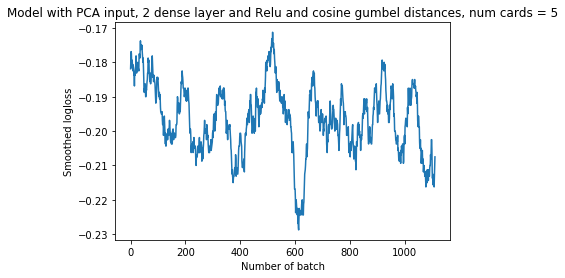

In [71]:
N = 50
mean_loss = np.convolve(np.array(history_loss), np.ones((N,))/N, mode='valid')
#title = 'Model with 2 dense layers and ReLu and inverted 1 dense distances, num cards = %s' % num_cards
title = 'Model with PCA input, 2 dense layer and Relu and cosine gumbel distances, num cards = %s' % num_cards
fig = plt.plot(list(range(len(history_loss) - N + 1)), mean_loss)
plt.xlabel('Number of batch')
plt.ylabel('Smoothed logloss')
plt.title(title)
savefig('pictures/%s.png'%title)
torch.save(ImaginariumModel, 'models/%s'%title) 


 Описание экспериментов.
 
 Ссылка на скрипт с экспериментами на гитхабе
 
 
 
 У нас  есть множество картинок и множество слов.  Глобальная задача - в игре из как минимум 3 игороков научиться подбирать нетривиальные ассоциации водящего под выбранную картинку, так чтобы оставшиеся 2 игрока в части случаев понимали, а в части случаев не понимали, кому из игроков принадлежит картинка, под которую подобрана ассоциация. В качестве бейзлайна под эту задачу предлагается рассмотреть задачу 2 игроков - 1 игрок загадывает ассоциацию к 1 картинке из k(5 или 10), а 2 игрок по этой ассоциации пытается понять, какую из k картинок выбрал игрок. 
 
В качестве картинок рассматривается коллекция из ~200 изображений из игры "Имаджинариум", в качестве слов ~ 1000 самых популярных слов английского языка. Обучающая выборка гененируется следующим образом - из множества картинок случайно выбираем k картинок, из них случайно одну картинку. Задача сети - по картинке подобрать такое текстовое описание, чтобы сеть догадалась, какая из k картинок была выбрана. Набор из k картинок и всех слов подается в некую сеть (полносязную). Полученные после этого представления идут в  часть сетки, которая считает расстояние между представлением k картинок и всеми словами, пропускает через softmax, усредняя после этого полученные векторы слов. Далее к полученному вектору слов ищется ближайшая из k картинок картинка.
 
 Какие параметры пробовала менять:
 
 1) Менять количество карт на руках у игрока
 
 2) После подсчета финальных расстояний между всеми картами у ведущего игрока и его текстовой ассоциации, обрабатывать его полносвязной сетью
 
 3) Различные конфигурации сетки, которая обрабатывает картинко-текстовове пространство (полносвязная, 2 полносвязные+ relu, полносвязная+relu)
 
 4) Пропускать изначальное пространство кросс-эмбеддингов через PCA, чтобы сократить размерность пространства с 1024 до, например, 100.
 
 5) Вместо softmax при выборе текстовых векторов, ближайших к ставить gumbel softmax
 
 6) Различные метрики расстояния 
 
 
 Текущие успехи(по сравнению с предыдущим):
 
 1) Модель переведена на торч 
 
 2) По модели текут градиенты, на повторяющихся данных удается добиться переобучения :)
 
 3) Попробованы и выписаны разные варианты сети, которые можно быстро запихнуть в другие модели
 
 4) Модель как-то учится
 
 
 Примеры более или менее удачных попыток:
 
 Пример переобучения
 
 
 
 
  Актуальные проблемы:
 
 1) Учится очень медленно
 
 2) Гумбеловский софтмакс не очень помогает
 

 
 
 Планы на ближайшее будущее:
 
 1) Распространить бейзлайн на игру из трех игроков - возможно это поможет с обучением.
 
 2) Сделать как в attention - вместо расстояний подставить dense слои с attention
 
 2) Переписать применение dense слоев более оптимально
 
 3) Провести эксперименты с предложениями вместо слов и другими картинками
 
 4) Влезть в ImageCaptioning

# Черновик

### Текущая сеть

In [ ]:



class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.dense = nn.Linear(1024, 100)

    def forward(self, input_true_image,
                input_k_images, input_all_words):
        
        prepr_true_image = self.dense(input_true_image)
        print(prepr_true_image.shape)
        prepr_all_words = self.dense(input_all_words)
        prepr_k_images = self.dense(input_k_images)
        
        distance_words = nn.modules.distance.PairwiseDistance(prepr_true_image, prepr_all_words)
        weights_words = nn.Softmax(distance_words)
        one_word = torch.prod(weights_words, prepr_all_words)
        k_same_words = one_word.repeat(k).resize_(998,k).transpose(-2,1)
        
        distance_images = nn.modules.distance.PairwiseDistance(prepr_true_image, k_same_words)
        output_probs_images = nn.Softmax(distance_images)
        
        return output_probs_images


net = Net()
print(net)

In [ ]:
class Print(nn.Module):
    def __init__(self):
        super(Print, self).__init__()

    def forward(self, x):
        print(x.shape)
        return x

In [ ]:
Print()

### Решейпим

In [ ]:
X_true_img = X_true_img.reshape( num_samples, num_words, 1024)
# Эмбеддинги для всех текстов
X_all_texts = X_all_texts.reshape(num_samples, num_words, 1024)
# Решейплю
X_images = X_images.reshape(k, num_samples, 1024)
# Ответы
y_true_image = np.array(y_true_image).reshape(1, num_samples, k)


In [ ]:
from torch.utils.data import DataLoader

X_true_img_torch = torch.FloatTensor(np.array(X_true_img))
X_images_torch = torch.FloatTensor(np.array(X_images))
X_all_texts_torch = torch.FloatTensor(np.array(X_all_texts))
#X = torch.stack([X_true_img, X_images, X_all_texts], dim = 2)
y_torch = torch.FloatTensor(y_true_image)
trainloader = DataLoader([X_true_img_torch,
                                X_images_torch,
                                X_all_texts_torch,
                                y_torch],
                               batch_size=4,
                               shuffle=False,
                               num_workers=2)


### Дебажим

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

### Модели

In [ ]:
model_hard.fit([X_images, X_true_img, X_all_texts],y_true_image, epochs = 10, 
                verbose = True, batch_size = 50, validation_split=0.1) 

### Генератор

In [ ]:
# Сэмплируем случайные num_cards векторов
def generate_arrays_from_file(image_vectors, words_vectors,
                              batch_size = 50, num_cards = 10,
                              num_words = 998):
    while 1:
        X_images = []
        y_true_image = []
        for i in range(batch_size):
            img = np.array(sample(range(1,len(image_vectors)), num_cards))
            X_images.append(img)
            true_image = sample(img, 1)
            y_true_image.append(np.array([1 if x==true_image
                                          else 0 for x in X_images[i]]))
        # Эмбеддинги для всех картинок
        X_images = image_vectors[X_images].reshape(num_samples,
                                                   1024, num_cards)
        # Эмбеддинги для правильной картинки, размноженные 10 раз
        t =np.array(X_images)[:,:,np.argmax(y_true_image)]
        X_true_img = np.repeat(t.reshape(t.shape[0],t.shape[1],1),
                               num_words,axis =2).reshape(num_samples,
                                                          num_words, 1024)
        # Эмбеддинги для всех текстов
        X_all_texts = np.repeat(words_vectors.reshape(
            1, num_words, 1024),num_samples, axis = 0 )
        # Решейплю
        X_images = X_images.reshape(batch_size,
                                    num_cards, 1024)
        # Ответы
        y_true_image = np.array(y_true_image).reshape(batch_size,
                                                      1, num_cards)
        yield ([X_images, X_true_img, X_all_texts], y_true_image)
   

In [ ]:
# Дампим массив, в котором содержатся индексы  топ10,
# близких по mse слов-ассоциаций к картинке для каждой картинки
with open('preprocessed_data/idx_words_array.pickle', 'rb') as f:
    idx_words_array = pickle.load( f)
# Дампим массив, в котором содержатся индексы  топ10,
# близких по mse слов-ассоциаций к картинке для каждого ckjdf
with open('preprocessed_data/idx_images_array.pickle', 'rb') as f:
    idx_images_array = pickle.load( f)
# Дампим массив, в котором содержатся инфа о том,
# в скольки процентах случаев это слово входит в топ-10 ближайших для всех картинок
with open('preprocessed_data/norm_idx_words_array.pickle', 'rb') as f:
    norm_idx_words_array = pickle.load( f, encoding='latin1')
# Дампим массив, в котором содержатся инфа о том,
# в скольки процентах случаев эта картинка входит в топ-10 ближайших для всех слов
with open('preprocessed_data/norm_idx_images_array.pickle', 'rb') as f:
    norm_idx_images_array = pickle.load( f, encoding='latin1')
# Дампим массив, в котором содержатся расстояние до топ k слов 
with open('preprocessed_data/mse_words_top_array.pickle', 'rb') as f:
    mse_words_top_array = pickle.load( f, encoding='latin1')
# Дампим массив, в котором содержатся расстояние до топ k слов 
with open('preprocessed_data/mse_words_top_array.pickle', 'rb') as f:
    mse_words_top_array = pickle.load( f, encoding='latin1')